### Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from io import StringIO

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# -------------------------------
# 1. Cargar datos
# -------------------------------
df = pd.read_csv("diamonds.csv")
df = df.drop(columns=["id"])

# -------------------------------
# 2. Log-transform de price
# -------------------------------
y = np.log(df["price"])   # <-- aquí el log
X = df.drop(columns=["price"])

# -------------------------------
# 3. Split train/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 4. Columnas categóricas y numéricas
# -------------------------------
categorical_cols = ["cut", "color", "clarity"]
numeric_cols = ["carat", "depth", "table", "x", "y", "z"]

# -------------------------------
# 5. One-hot encoding
# -------------------------------
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat  = encoder.transform(X_test[categorical_cols])

# -------------------------------
# 6. Escalado de variables numéricas
# -------------------------------
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num  = scaler.transform(X_test[numeric_cols])

# -------------------------------
# 7. Combinar numéricas + categóricas
# -------------------------------
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final  = np.hstack([X_test_num,  X_test_cat])

# -------------------------------
# 8. Escalado de la variable objetivo (opcional, pero útil para NN)
# -------------------------------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))  # <-- solo transform

# -------------------------------
# 9. Convertir a numpy arrays
# -------------------------------
y_train_scaled = np.array(y_train_scaled)
y_test_scaled  = np.array(y_test_scaled)

print("Shape X_train:", X_train_final.shape)
print("Shape X_test :", X_test_final.shape)
print("Shape y_train:", y_train_scaled.shape)
print("Shape y_test :", y_test_scaled.shape)


Shape X_train: (43152, 26)
Shape X_test : (10788, 26)
Shape y_train: (43152, 1)
Shape y_test : (10788, 1)


### PyTorch

In [61]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [62]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, dropout_rate=0.5):
        super().__init__()
        # Definimos la capa Dropout
        self.dropout = nn.Dropout(p=dropout_rate) # Usando 0.5 como valor estándar
        
        self.flatten = nn.Flatten()
        
        # Insertamos la capa Dropout en el stack
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.Tanh(),
            # 1. Añadimos Dropout después de la primera ReLU
            self.dropout, 
            nn.Linear(64, 32),
            nn.Tanh(),
            self.dropout, 
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [63]:
model = NeuralNetwork(n_features=X_train_final.shape[1])
print(model)

NeuralNetwork(
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [64]:
# 4. Convertir a tensores
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

In [65]:
epochs = 400

train_losses = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Entrenamiento
for epoch in range(epochs):
    # Forward
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()  # reiniciar gradientes
    loss.backward()        # calcular gradientes
    optimizer.step()        # actualizar pesos

    train_losses.append(loss.item())
    

    # Mostrar progreso
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [20/400], Loss: 0.244202
Epoch [40/400], Loss: 0.146313
Epoch [60/400], Loss: 0.118019
Epoch [80/400], Loss: 0.104028
Epoch [100/400], Loss: 0.096409
Epoch [120/400], Loss: 0.089624
Epoch [140/400], Loss: 0.086034
Epoch [160/400], Loss: 0.082541
Epoch [180/400], Loss: 0.078871
Epoch [200/400], Loss: 0.075948
Epoch [220/400], Loss: 0.073790
Epoch [240/400], Loss: 0.072804
Epoch [260/400], Loss: 0.071538
Epoch [280/400], Loss: 0.069982
Epoch [300/400], Loss: 0.069782
Epoch [320/400], Loss: 0.069272
Epoch [340/400], Loss: 0.068380
Epoch [360/400], Loss: 0.068211
Epoch [380/400], Loss: 0.066999
Epoch [400/400], Loss: 0.066381


In [66]:
# Predicciones del modelo
model.eval()  # modo evaluación (sin dropout, etc)
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()

# Convertir a numpy si hace falta
y_true = y_train_tensor.numpy()

# Calcular R²
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_true, y_pred_train)
mse = mean_squared_error(y_true, y_pred_train)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")


R²: 0.9772
MSE: 0.0228


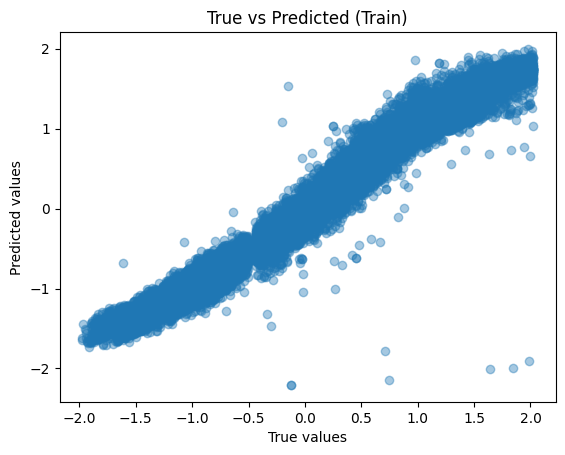

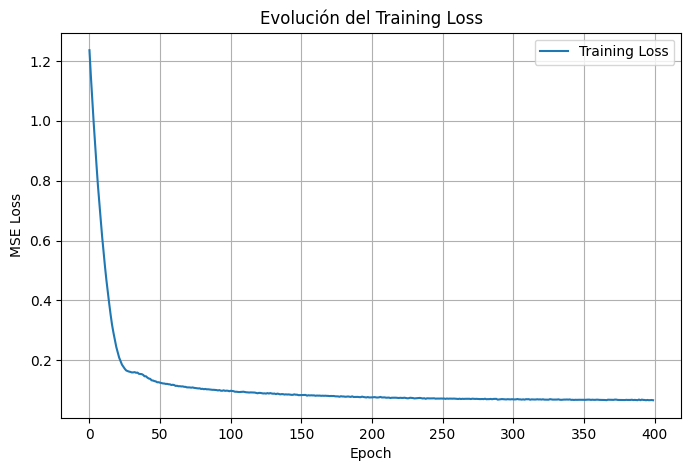

In [67]:
plt.scatter(y_true, y_pred_train, alpha=0.4)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted (Train)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Evolución del Training Loss")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
model.eval()  # Modo evaluación: desactiva dropout, batchnorm, etc.

with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)

print(f"Test Loss (MSE): {test_loss.item():.6f}")

Test Loss (MSE): 0.021601


In [69]:
from sklearn.metrics import r2_score

# Convertimos a numpy
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_test.numpy()

r2 = r2_score(y_test_np, y_pred_np)
print(f"R² en test: {r2:.4f}")

R² en test: 0.9785


### OWN NN

In [125]:
import numpy as np
from sklearn.model_selection import train_test_split


class NeuralNet:
    def __init__(self, layers, epochs=500, lr=0.001, momentum=0.3, 
                 function='tanh', perc_validation=0.2):
        """
        Inicializa la red neuronal.
        
        Args:
            layers: Lista con el número de neuronas por capa
            epochs: Número de iteraciones de entrenamiento
            lr: Learning rate (tasa de aprendizaje)
            momentum: Coeficiente de momentum
            function: Función de activación ('tanh' o 'sigmoid')
            perc_validation: Porcentaje de datos para validación
        """
        self.layers = layers
        self.epochs = epochs
        self.lr = lr
        self.momentum = momentum
        self.function = function
        self.perc_validation = perc_validation
        
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
        self.weights = []
        self.biases = []
        self.train_errors = []
        self.val_errors = []
        self.velocity_w = []
        self.velocity_b = []
        
        self.scaler_y = None  # Escalador de y para desnormalizar
        
        self._init_weights()
    
    def _init_weights(self):
        """Inicializa pesos y biases aleatoriamente (Xavier initialization)."""
        np.random.seed(42)
        self.weights = []
        self.biases = []
        self.velocity_w = []
        self.velocity_b = []
        
        for i in range(len(self.layers) - 1):
            limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
            w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            b = np.zeros((1, self.layers[i+1]))
            
            self.weights.append(w)
            self.biases.append(b)
            self.velocity_w.append(np.zeros_like(w))
            self.velocity_b.append(np.zeros_like(b))
    
    def _activation(self, x):
        """Aplica la función de activación."""
        if self.function == 'tanh':
            return np.tanh(x)
        elif self.function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        elif self.function == 'relu':
            return np.maximum(0, x)
    
    def _activation_derivative(self, x):
        """Derivada de la función de activación."""
        if self.function == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif self.function == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            return sig * (1 - sig)
        elif self.function == 'relu':
            return np.where(x > 0, 1, 0)
    
    def _forward(self, X):
        """Forward propagation. Retorna activaciones e inputs pre-activación."""
        activations = [X]
        z_values = []
        
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            
            if i < len(self.weights) - 1:  # No activación en la última capa
                a = self._activation(z)
            else:
                a = z  # Salida lineal
            
            activations.append(a)
        
        return activations, z_values
    
    def _backward(self, activations, z_values, y):
        """Backpropagation. Calcula gradientes."""
        m = y.shape[0]
        deltas = []
        
        # Error en la capa de salida
        error = activations[-1] - y
        deltas.append(error)
        
        # Backpropagate error
        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(deltas[0], self.weights[i+1].T) * self._activation_derivative(z_values[i])
            deltas.insert(0, delta)
        
        # Actualizar pesos y biases con momentum
        for i in range(len(self.weights)):
            dw = np.dot(activations[i].T, deltas[i]) / m
            db = np.sum(deltas[i], axis=0, keepdims=True) / m
            
            # Aplicar momentum
            self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.lr * dw
            self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.lr * db
            
            self.weights[i] += self.velocity_w[i]
            self.biases[i] += self.velocity_b[i]
    
    def _mse(self, y_true, y_pred):
        """Calcula el error cuadrático medio."""
        return np.mean((y_true - y_pred) ** 2)
    
    def fit(self, X, y, scaler_y=None):
        """
        Entrena la red neuronal.
        
        Args:
            X: Características de entrada (ya normalizadas)
            y: Etiquetas/valores objetivo (ya normalizados)
            scaler_y: Escalador de y para desnormalizar predicciones (opcional)
        """
        self.scaler_y = scaler_y
        # Split 80/20 entrenamiento/test
        X_train, self.X_test, y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Split del entrenamiento para validación
        if self.perc_validation > 0:
            split_idx = int(len(X_train) * (1 - self.perc_validation))
            self.X_train = X_train[:split_idx]
            self.X_val = X_train[split_idx:]
            self.y_train = y_train[:split_idx]
            self.y_val = y_train[split_idx:]
        else:
            self.X_train = X_train
            self.X_val = np.array([])
            self.y_train = y_train
            self.y_val = np.array([])
        
        # Asegurar que y tiene forma (n_samples, 1)
        if self.y_train.ndim == 1:
            self.y_train = self.y_train.reshape(-1, 1)
        if self.y_val.size > 0 and self.y_val.ndim == 1:
            self.y_val = self.y_val.reshape(-1, 1)
        if self.y_test.ndim == 1:
            self.y_test = self.y_test.reshape(-1, 1)
        
        # Entrenar
        self.train_errors = []
        self.val_errors = []
        
        for epoch in range(self.epochs):
            # Forward y backward en entrenamiento
            activations, z_values = self._forward(self.X_train)
            self._backward(activations, z_values, self.y_train)
            
            # Calcular error de entrenamiento
            train_pred, _ = self._forward(self.X_train)
            train_loss = self._mse(self.y_train, train_pred[-1])
            self.train_errors.append(train_loss)
            
            # Calcular error de validación
            if self.X_val.shape[0] > 0:
                val_pred, _ = self._forward(self.X_val)
                val_loss = self._mse(self.y_val, val_pred[-1])
                self.val_errors.append(val_loss)
            else:
                self.val_errors.append(None)
            
            if (epoch + 1) % 100 == 0:
                val_str = f", Val: {self.val_errors[-1]:.6f}" if self.val_errors[-1] is not None else ""
                print(f"Epoch {epoch + 1}/{self.epochs}, Train MSE: {train_loss:.6f}{val_str}")
    
    def predict(self, X):
        """
        Realiza predicciones.
        
        Args:
            X: Características de entrada (ya normalizadas)
            
        Returns:
            Predicciones
        """
        activations, _ = self._forward(X)
        return activations[-1]
    
    def predict_original_scale(self, X):
        """
        Realiza predicciones y las desnormaliza a escala original.
        
        Args:
            X: Características de entrada (ya normalizadas)
            
        Returns:
            Predicciones en escala original
        """
        predictions = self.predict(X)
        if self.scaler_y is not None:
            predictions = self.scaler_y.inverse_transform(predictions)
        return predictions
    
    def loss_epochs(self):
        """
        Retorna los errores de entrenamiento y validación por epoch.
        
        Returns:
            Tupla (train_errors, val_errors)
        """
        return self.train_errors, self.val_errors

In [126]:
# 1. Cargar datos
df = pd.read_csv("diamonds.csv")
df = df.drop(columns=["id"])

# 2. Selección de 500 filas aleatorias
df = df.sample(n=500, random_state=42).reset_index(drop=True)

# 3. Separar variables
X = df.drop(columns=["price"])
y = df["price"]

# 4. One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# 5. Escalado después del split
scaler_x = StandardScaler()
X_nn = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_nn = scaler_y.fit_transform(y.values.reshape(-1, 1))

Epoch 100/1000, Train MSE: 0.132425, Val: 0.268222
Epoch 200/1000, Train MSE: 0.110238, Val: 0.244672
Epoch 300/1000, Train MSE: 0.093976, Val: 0.228433
Epoch 400/1000, Train MSE: 0.081199, Val: 0.215175
Epoch 500/1000, Train MSE: 0.070853, Val: 0.203877
Epoch 600/1000, Train MSE: 0.062355, Val: 0.194150
Epoch 700/1000, Train MSE: 0.055337, Val: 0.185804
Epoch 800/1000, Train MSE: 0.049530, Val: 0.178707
Epoch 900/1000, Train MSE: 0.044717, Val: 0.172734
Epoch 1000/1000, Train MSE: 0.040717, Val: 0.167753
MSE: 2307585.65
MAE: 1098.70
R2: 0.9027
MAPE: 43.90%


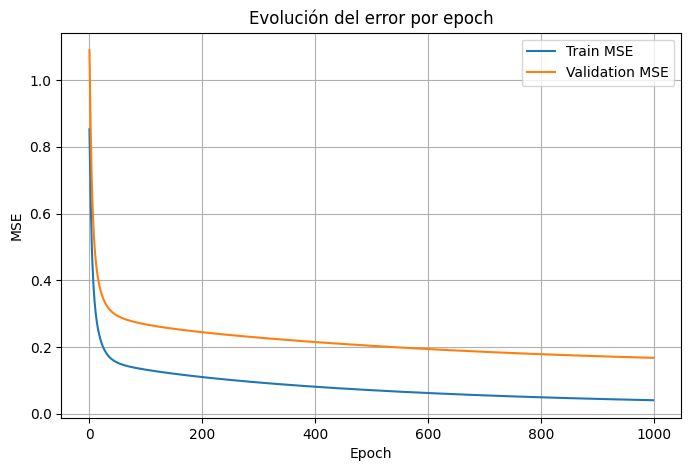

In [ ]:
net = NeuralNet(
    layers=[23, 64, 16, 1],
    epochs=1000,
    lr=0.01,
    momentum=0.4,
    function='tanh',
    perc_validation=0.2,
)

net.fit(X_nn, y_nn, scaler_y=scaler_y)

# 7. Predicciones en escala original
predictions = net.predict_original_scale(net.X_test)
y_test_original = scaler_y.inverse_transform(net.y_test)

# 8. Métricas
mse = mean_squared_error(y_test_original, predictions)
mae = mean_absolute_error(y_test_original, predictions)
r2 = r2_score(y_test_original, predictions)
mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# 9. Gráficar errores
train_errors, val_errors = net.loss_epochs()
plt.figure(figsize=(8,5))
plt.plot(train_errors, label="Train MSE")
if net.X_val.shape[0] > 0:
    plt.plot([e for e in val_errors if e is not None], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Evolución del error por epoch")
plt.legend()
plt.grid(True)
plt.show()